### Deep Hedging

Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Evaluation of how good $V_{T}$ hedge $Z$ by convex risk measure $\rho$
$$
\rho(-Z + V_T).
$$
By cash invariant of convex risk measure we have 
$$
\rho(-Z + V_T) = \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0,
$$
which means that the risk increase at maturity $T$ is indeed how much we subtract at time $0$, so implicitly we are actually compare the discounted value. This idea is also reflected in the definition of OCE measure below (a special case of convex risk measure).

Our goal is to find the best strategy $H$ under $\rho$:
$$
\pi(-Z) = \min_{H} \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0.
$$
In particular we choose OCE measure 
$$
\rho(X) = \inf_{w \in \mathbb{R}}\{w + \mathbb{E}_{\mathbb{P}}[l(-X-w)]\}
$$
where $l(x)$ represent risk (with $u$ to be utility function).
- Entropic risk measure: $l(x) = \exp(\lambda x) - \frac{1}{\lambda}(1+\log\lambda)$, $\lambda > 0$
\begin{align*}
\rho(X) &= \frac{1}{\lambda}\log\Big(\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)\\
\omega^{*} &= \frac{1}{\lambda}\log\Big(\lambda\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)
\end{align*}

- Expected shortfall: $l(x) = \frac{1}{1-\alpha}\max(x,0)$, $\alpha \in (0,1)$
\begin{align*}
\rho(X) &= \frac{1}{1-\alpha}\int_{0}^{1-\alpha}\mathrm{VaR}_{\gamma}(X)d\gamma\\
\omega^{*} &= -\mathrm{VaR}_{1-\alpha}(X)
\end{align*}

- Square loss: $l(x) = \frac{x^2 + 1}{2}$
\begin{align*}
\rho(X) &= \frac{1}{2}\mathrm{Var}_{\mathbb{P}}[X] -  \mathbb{E}_{\mathbb{P}}[X] \\
\omega^{*} &= -\mathbb{E}_{\mathbb{P}}[X]
\end{align*}
At the end we specify $V_0 = \omega^{*}$ to be the initial wealth i.e. the price of payoff. 

Numerically, we are solving the following minimization problem 
$$
\rho(X) = \inf_{H \in \mathcal{NN}}\inf_{V_0 \in \mathbb{R}}\Big\{V_0 + \mathbb{E}_{\mathbb{P}}\Big[l\big(Z + C_T - V_T \big)\big)\Big]\Big\}
$$

- ! Price process need to be discounted



In [1]:
%load_ext autoreload
%autoreload 2
import torch
from os import makedirs
from neuralhedge.nn import datahedger, mlp, loss, blackschole
from neuralhedge.nn.loss import EntropicRiskMeasure, SquareMeasure, ExpectedShortfall
from neuralhedge._utils.plotting import plot_pnl, plot_history, plot_data, plot_hedge
from neuralhedge.data.stochastic import BlackScholesDataset, simulate_time
from neuralhedge.nn.contigent import EuropeanVanilla

### Black-Scholes & European Call

In [2]:
n_sample = 50000
n_timestep = 30
dt = 1/365

ds_bs = BlackScholesDataset(n_sample = n_sample,
                          n_timestep = n_timestep,
                          dt = dt)
paths = ds_bs.paths*100


contigent = EuropeanVanilla(strike = 100., call = True)
payoff = contigent.payoff(paths[:,-1,0])

info1 = torch.log(paths)
info2 = simulate_time(n_sample, dt, n_timestep, reverse = True)
info = torch.cat([info1,
                  info2],
                  dim = -1)
data = [paths, info, payoff]

Shape of paths:  torch.Size([50000, 31, 1])
Shape of information:  torch.Size([50000, 31, 2])
Shape of payoff:  torch.Size([50000])


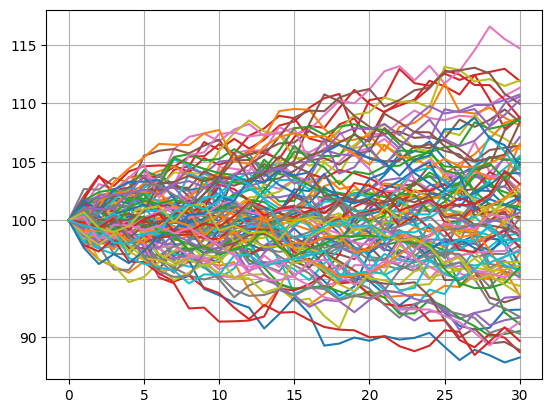

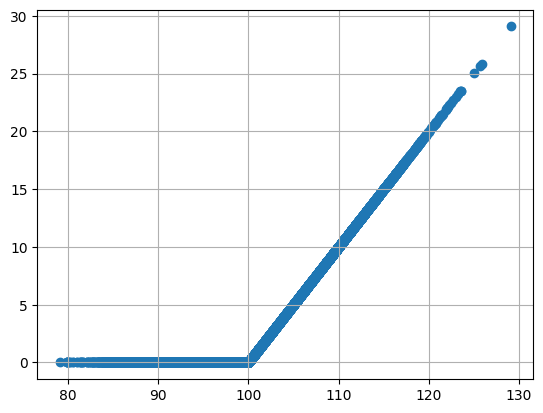

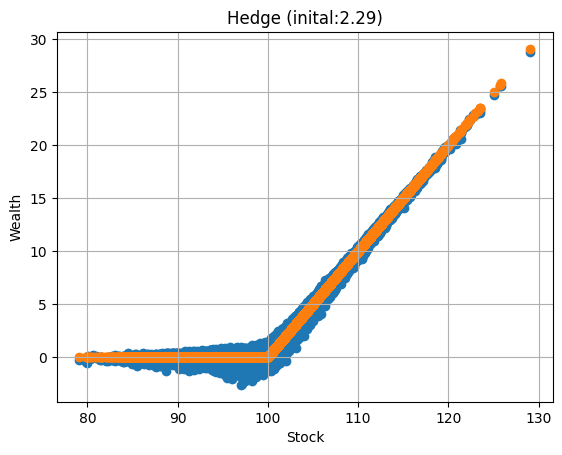

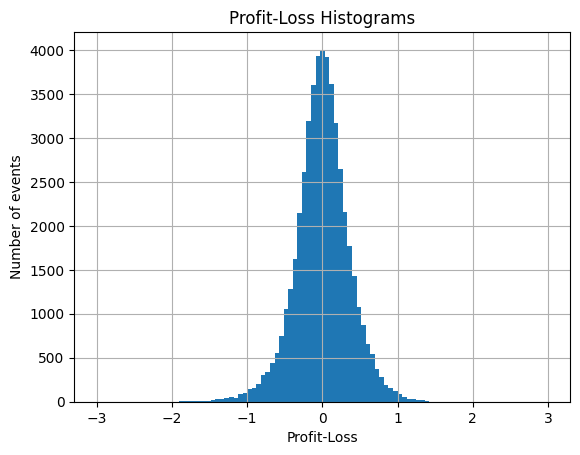

In [3]:
data = [paths, info, payoff]
hedge_ds = datahedger.HedgerDataset(data)
model_delta = blackschole.BlackScholesDelta(sigma = ds_bs.sigma,
                                      risk_free_rate = 0.,
                                      strike = contigent.strike)
bs_pricer = blackschole.BlackScholesPrice(sigma = ds_bs.sigma,
                                      risk_free_rate = 0.,
                                      strike = contigent.strike)
bs_price = bs_pricer(info[0,0])[0]
hedger = datahedger.Hedger(model_delta) 

plot_data(data)
plot_hedge(hedger, hedge_ds.data, init_wealth=bs_price)

### Data Hedger


In [4]:
EPOCHS = 50

#### Entropic Risk Measure

/Users/hous/Documents/GitHub/NeuralHedge/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=3.8223254680633545: 100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


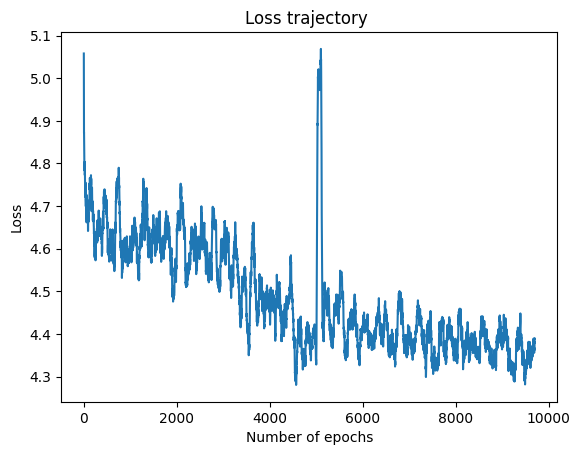

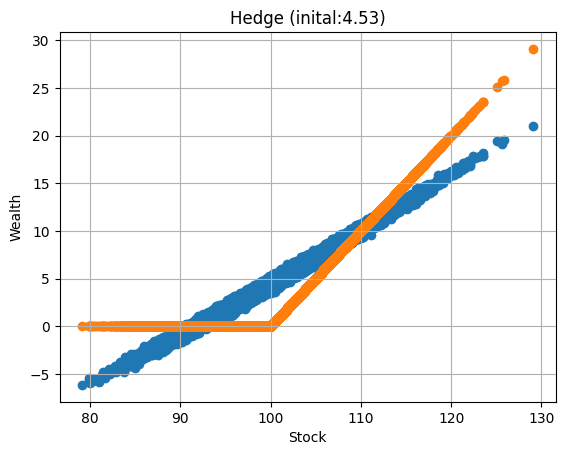

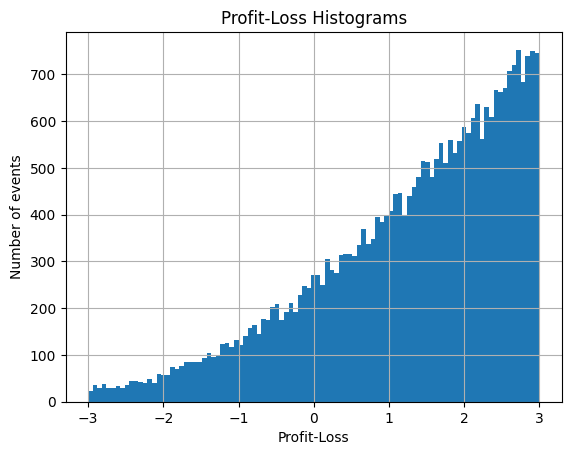

In [5]:
# record_dir = './examples/numerical_results/bs_call_entropic/'
# makedirs(record_dir, exist_ok=True)
record_dir = None
model = mlp.NeuralNetSequential(n_output = paths.shape[-1])
hedger = datahedger.Hedger(model) 
hedger.fit(hedge_ds, EPOCHS=EPOCHS, risk=EntropicRiskMeasure(), record_dir=record_dir) 
price = hedger.pricer(data)
plot_history(hedger.history, record_dir = record_dir)
plot_hedge(hedger, data, price, record_dir = record_dir)

#### Square loss

/Users/hous/Documents/GitHub/NeuralHedge/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=2.4148507118225098: 100%|██████████| 50/50 [02:07<00:00,  2.54s/it]


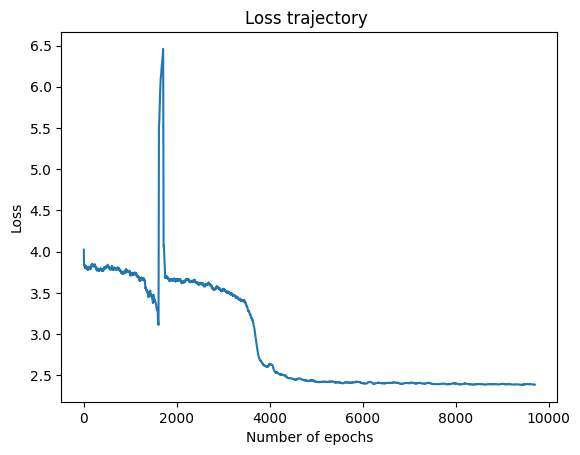

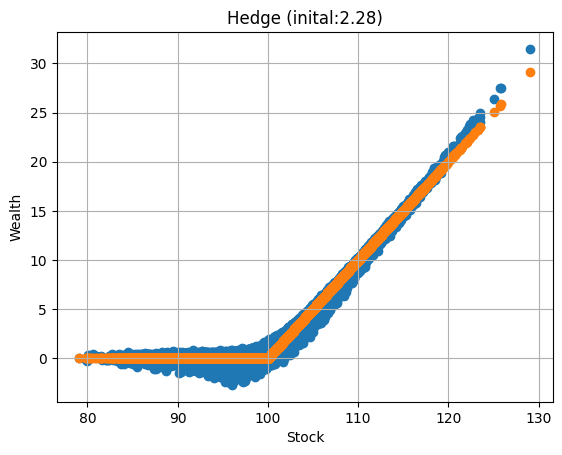

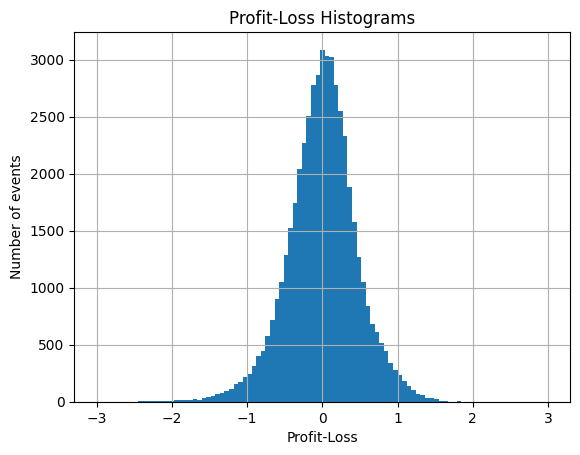

In [6]:
# record_dir = './examples/numerical_results/bs_call_square/'
# makedirs(record_dir, exist_ok=True)
record_dir = None
model = mlp.NeuralNetSequential(n_output = paths.shape[-1])
hedger = datahedger.Hedger(model) 
hedger.fit(hedge_ds, EPOCHS=EPOCHS, risk=SquareMeasure(), record_dir=record_dir) 
price = hedger.pricer(data)
plot_history(hedger.history, record_dir = record_dir)
plot_hedge(hedger, data, price, record_dir = record_dir)

#### Expected shorfall

Loss=3.7164597511291504: 100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


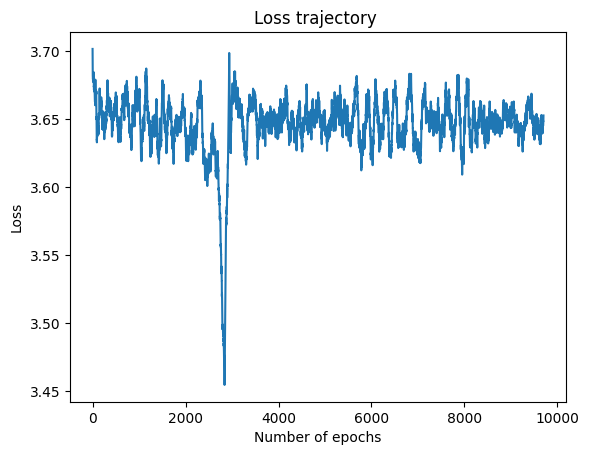

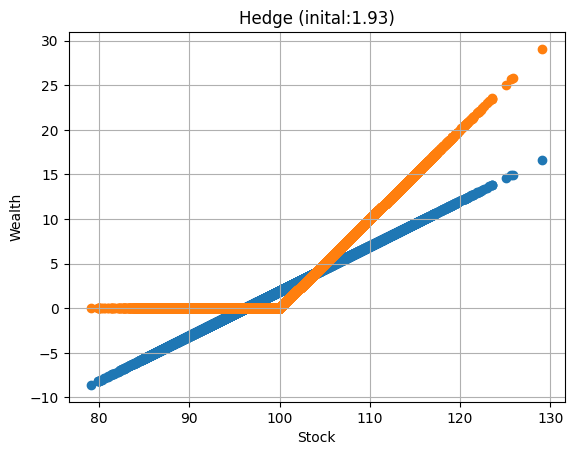

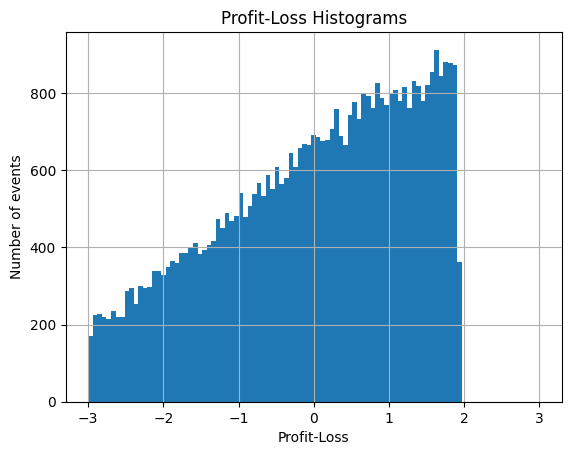

In [7]:
alpha = 0.5
q = 1-alpha
# record_dir = './examples/numerical_results/bs_call_es50'
# makedirs(record_dir, exist_ok=True)
record_dir = None
model = mlp.NeuralNetSequential(n_output = paths.shape[-1])
hedger = datahedger.Hedger(model) 
hedger.fit(hedge_ds, EPOCHS=EPOCHS, risk=ExpectedShortfall(q), record_dir=record_dir) 
price = hedger.pricer(data)
plot_history(hedger.history, record_dir = record_dir)
plot_hedge(hedger, data, price, record_dir = record_dir)

Loss=7.626795291900635: 100%|██████████| 50/50 [02:08<00:00,  2.56s/it] 


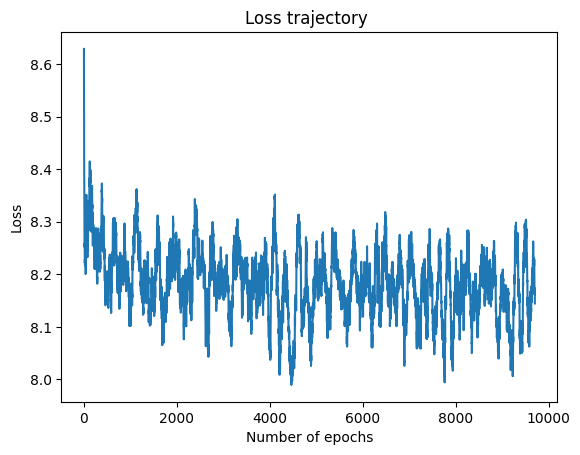

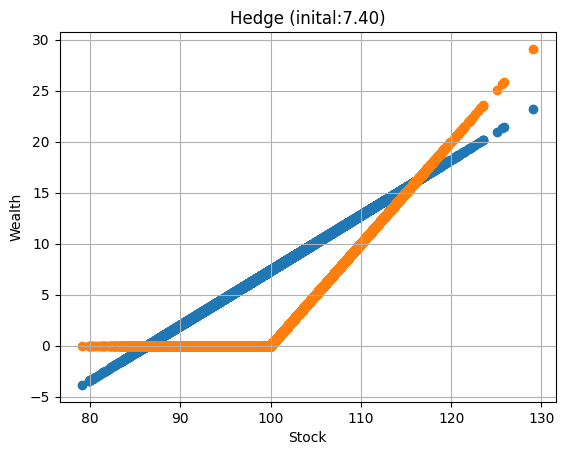

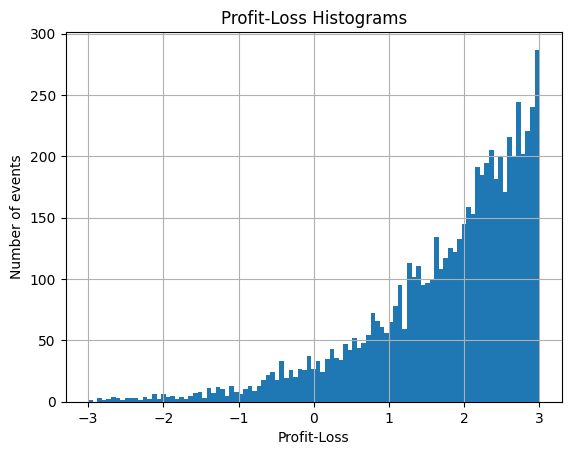

In [8]:
alpha = 0.99
q = 1-alpha
# record_dir = './examples/numerical_results/bs_call_es99'
# makedirs(record_dir, exist_ok=True)
record_dir = None
model = mlp.NeuralNetSequential(n_output = paths.shape[-1])
hedger = datahedger.Hedger(model) 
hedger.fit(hedge_ds, EPOCHS=EPOCHS, risk=ExpectedShortfall(q), record_dir=record_dir) 
price = hedger.pricer(data)
plot_history(hedger.history, record_dir = record_dir)
plot_hedge(hedger, data, price, record_dir = record_dir)